# ELETRONIC HOUSE - TEST A/B

# IOT Method

## Input

### Business Case

 I. Business problem + Kaggle data

## Output

 I. A sentence saying whether page A is better than page B.
 
 II. Page sales potential
 
 III. Product revenue potential.

## Tasks

I. Experiment planning.

II. Get the data.

III. Check data validation.

IV. Study the descriptive statistics of the data.

V. Create the hypotheses. Explore the Data (Understanding Distributions)

VII. Stipulating a test goal (2%)

VIII. Stipulate the significance level of the test.

IX. Define what will be the statistical test

X. Apply the statistical test (Permutation test)

XI. Compare the distribution of the 2 pages and see if there is a difference statistically relevant.

XII. Deliver the result (see Output

OBS: The goal impact directly in the size of the dataset.


# 0.0 IMPORTS

In [121]:
import os
# import lux
import pickle
import warnings
import inflection
import sweetviz                     as sv
import pandas                       as pd
import numpy                        as np
import seaborn                      as sns
import matplotlib.pyplot            as plt
import IPython
from IPython.core.display           import HTML
from scipy.stats                    import chi2_contingency,shapiro
from statsmodels.stats import api as sms
import math
from statsmodels.stats import proportion as p

# import handcalcs.render


##  Helper Functions

In [12]:


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
warnings.filterwarnings("ignore")


#Function to plot correlation of a column 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Greens').set_title(col);
    
    return plot

# cramer V function to calculate correlation btw categorical variables
def cramer_v(x, y):
    # Confusion Matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def descriptive_statistics(df1_num):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

##  Load dataset

In [4]:
df_raw=pd.read_csv('/home/tc0019/DS/pa007/data/raw/ab_data.csv')
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#  1.0 DATA DESCRIPTION

In [5]:
df1=df_raw.copy()

## 1.1. Rename Columns

All columns will be renamed to snake case: https://en.wikipedia.org/wiki/Snake_case.

The main objective is create a columns name pattern to make simple dealing with the dataset.

In [5]:
df1.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [6]:
cols_old=['user_id', 'timestamp', 'group', 'landing_page', 'converted']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
rows_, columns_= df1.shape

print( f'Number of Rows: {rows_}\nNumber of Columns: {columns_}')

Number of Rows: 294478
Number of Columns: 5


## 1.3. Data Types

In [8]:
df1.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

### 1.3.1 Changing datatype

In [18]:
df1['timestamp']=pd.to_datetime(df1['timestamp']).apply(lambda x: x.strftime('%Y-%m-%d'))

## 1.4. Check NA

 The dataset has no occurrence of NAs

In [10]:
df1.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## 1.5. Descriptive Statistics

In [11]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [13]:
descriptive_statistics(df1_num)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
user_id,630000,945999,315999,787974.124733,787933.5,91210.668907,0.000895,-1.200045,not normal
converted,0,1,1,0.119659,0.0,0.324563,2.343725,3.493071,not normal


In [13]:
df1_cat.head()

,group,landing_page
0,control,old_page
1,control,old_page
2,treatment,new_page
3,treatment,new_page
4,control,old_page


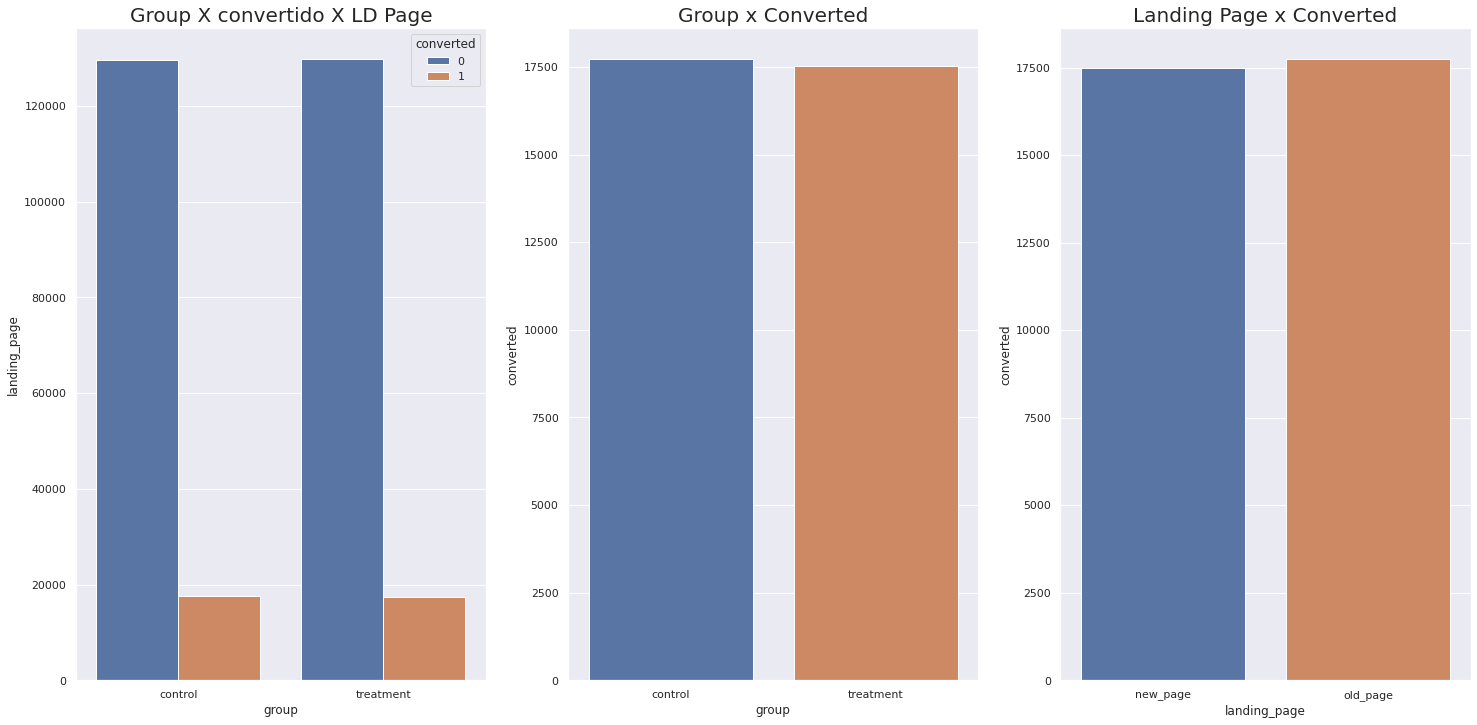

In [14]:
plt.subplot(1,3,1)
aux2=df1[['group', 'landing_page','converted']].groupby(['group','converted']).count().reset_index()
sns.barplot(x='group', y='landing_page', hue='converted', data=aux2).set_title('Group X convertido X LD Page', fontsize=20);

plt.subplot(1,3,2)
aux1=df1[['group','converted']].groupby('group').sum().reset_index()
sns.barplot(x='group',  y='converted', data=aux1).set_title('Group x Converted', fontsize=20);
plt.ticklabel_format(style='plain', axis='y')


plt.subplot(1,3,3)
aux=df1[['landing_page','converted']].groupby(['landing_page']).sum().reset_index()
sns.barplot(x='landing_page', y='converted', data=aux).set_title('Landing Page x Converted', fontsize=20)
plt.show()


## 1.6 Visualization

In [19]:
my_report = sv.analyze(df1)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# 2.0 EDA

In [20]:
df2 = df1.copy()
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [22]:
print(df2.timestamp.min())
print(df2.timestamp.max())

2017-01-02
2017-01-24


###  2.1 Hypotheses List

1. The current landing page converts more than the new one.
2. The new land page convert more in the first 5 days.
3. The median converted is the same.


1. The current landing page converts more than the new one.


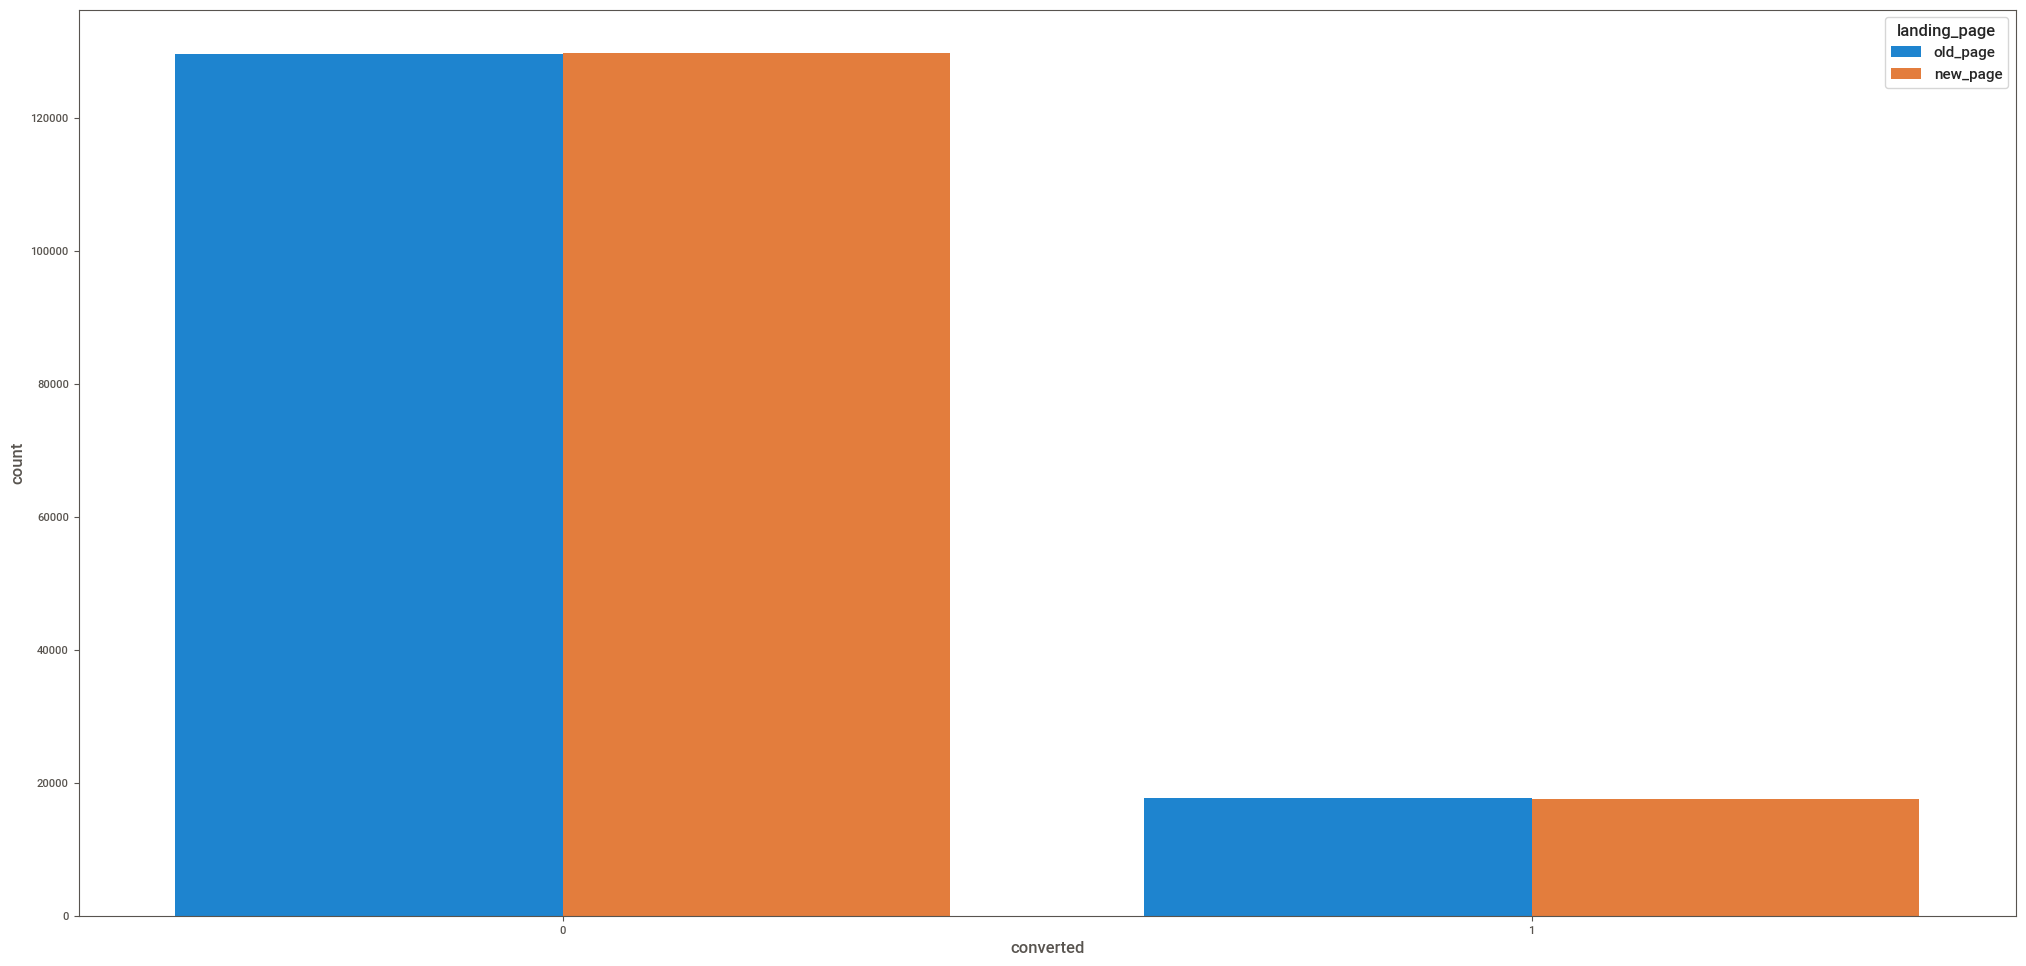

In [78]:
sns.countplot(x='converted', hue='landing_page', data=df2);

2. The new land page convert more in the first 5 days.
    - FALSE the new page is converting 30 clients less than the current page in the first five days.

In [79]:
aux1=df2[['user_id', 'landing_page','converted','timestamp']].groupby(['timestamp', 'landing_page']).agg({'user_id': ['count'],'converted': ['sum']}).reset_index()
aux1.columns=['timestamp', 'landing_page','count_id', 'sum_converted']

df_new_page5=aux1.loc[(aux1['timestamp']<='2017-01-06') & (aux1['landing_page']=='new_page')]
df_old_page5=aux1.loc[(aux1['timestamp']<='2017-01-06') & (aux1['landing_page']=='old_page')]

print(f'The total clients converted using the NEW PAGE in the first five days are: {df_new_page5.sum_converted.sum()}')
print(f'The total clients converted using the CURRENT PAGE in the first five days are: {df_old_page5.sum_converted.sum()}')

The total clients converted using the NEW PAGE in the first five days are: 3485
The total clients converted using the CURRENT PAGE in the first five days are: 3515


3. The average converted is the same.
    - True the average converted is the same.

In [49]:
aux=df2[['group', 'converted']].groupby('group').agg('sum').reset_index()
aux['grp_mean']=100*(aux['converted']/df2.shape[0]).round(2)
aux.head()

,group,converted,grp_mean
0,control,17723,6.0
1,treatment,17514,6.0


# 3.0 Experiment Design

In [83]:
df3=df2.copy()

## 3.1 Hypotheses Formulation

- H0: The current convertion rate is better than the new page convertion rate.
- H1: The new page convertion overcomes the current page convertion rate.

## 3.2 Experiment Parameters

In [81]:
confidence_level=0.95
significance_level=0.05

# page conversions 
p1=0.13
p2=0.15
effect_size=sms.proportion_effectsize(p1, p2)
statistical_power=0.80

# sample size
sample_n=sms.NormalIndPower().solve_power(effect_size, power=statistical_power, alpha=significance_level)
sample_n=math.ceil(sample_n)
sample_n

4720

## 3.2 Check A/B Flag

In [84]:
df3[['user_id','group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [85]:
duplicated_user_grp=df3[['user_id','group']].groupby(['user_id']).count().reset_index().query( 'group > 1')
duplicated_user_grp.head()

,user_id,group
43,630052,2
111,630126,2
122,630137,2
281,630320,2
420,630471,2


In [21]:
df3[df3['user_id']==630126]

,user_id,timestamp,group,landing_page,converted
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0


In [86]:
df31=df3[~df3['user_id'].isin(duplicated_user_grp['user_id'])]
df31.shape

(286690, 5)

In [88]:
df31[['user_id', 'group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


# 4.0 Sample

In [89]:
df_control_sample=df31[df31['group']=='control'].sample(n=sample_n, random_state=42)
df_treatment_sample=df31[df31['group']=='treatment'].sample(n=sample_n, random_state=42)

df_ab=pd.concat([df_control_sample, df_treatment_sample])
df_ab.shape

(9440, 5)

In [90]:
df_treatment_sample.shape

(4720, 5)

In [91]:
df_control_sample.shape

(4720, 5)

# 5.0 Conversion Rate

- explicit method to calculate conversion rate
- GMV metric

In [108]:
visitors=df_control_sample.shape[0]
buyers=df_control_sample[df_control_sample['converted']==1].shape[0]
con_rate=(buyers/visitors)
"The conversion rate is: {:.2f}".format(con_rate)

'The conversion rate is: 0.12'

In [110]:
df_control_sample['converted'].agg(['mean', 'std'])

mean    0.115466
std     0.319617
Name: converted, dtype: float64

In [111]:
df5=df_ab[['group', 'converted']].groupby('group').agg({'converted':['mean', 'std']})
df5.columns=['conversion_rate', 'standard_deviation']
df5.round(2).reset_index()

,group,conversion_rate,standard_deviation
0,control,0.12,0.32
1,treatment,0.13,0.34


# 6.0 Hypothesis Test

In [130]:
visitors_control=df_control_sample['converted'].count()
visitors_treatment=df_treatment_sample['converted'].count()

buyers_control=df_control_sample['converted'].sum()
buyers_treatment=df_treatment_sample['converted'].sum()

buyers= [ buyers_control, buyers_treatment ]
visitors= [visitors_control, visitors_treatment]

z_stat, pval=p.proportions_ztest(buyers, visitors)
print(z_stat.round(2))
print(pval.round(2))

if pval < 0.05:
    print('There is evidences to reject null hypothesis and assume the alternative - there is effect')
else:
    print('There is no evidence to reject the hypothesis - no effect')

-2.01
0.04
There is evidences to reject null hypothesis and assume the alternative - there is effect


In [128]:
df_table=df_ab[['group', 'converted']].groupby('group').agg({'converted':['sum', 'count']})
df_table.columns=['converted','not_converted']
df_table.head().reset_index()


chi_val, pval_chi, dof, expected = chi2_contingency(df_table)

print(chi_val.round(2))
print(pval_chi.round(2))


if pval_chi < 0.05:
    print('There is evidences to reject null hypothesis and assume the alternative - there is effect')
else:
    print('There is no evidence to reject the hypothesis - no effect')

3.05
0.08
There is no evidence to reject the hypothesis - no effect


Coclusion

# 7.0 PAGE CONVERSION TO INVOICE

- These pages have a good number of visitors
- A good page conversion is around 12% 
- Email is arround 22% 


In [ ]:
# What if the result was 15% of conversion ? how much money this would make?

current_page = 0.13
new_page=0.15
product=4500

df=df31.copy()

- daily_visitants * current_page = buyers
- buyers * product = Gross Margin Value

In [161]:
df=df31[['user_id','timestamp']].groupby(['timestamp']).count().reset_index()

# current GMV
df['current_purchases']= np.ceil(df['user_id'] * 0.13).astype(int)
df['current_gmv']=df['current_purchases'] * 4500
print(f'GMV on period: {df.current_gmv.sum()}')

# Expected GMV if 15% conversion occurs
df['new_purchases']= np.ceil(df['user_id'] * 0.15).astype(int)
df['new_gmv']=df['new_purchases'] * 4500
print(f'GMV on period: {df.new_gmv.sum()}')

current_gmv=df.current_gmv.sum()
new_gmv=df.new_gmv.sum()

absolute_lift=(new_gmv - current_gmv)
print(f'The absolute lift is: {absolute_lift}')
lift= 100*(new_gmv - current_gmv) / current_gmv
print(f'\nThe expected lift for the new page is: {lift.round(2)}%')

GMV on period: 167760000
GMV on period: 193563000
The absolute lift is: 25803000

The expected lift for the new page is: 15.38%


,user_id,timestamp,group,landing_page,converted,current_purchases,current_gmv,new_purchases,new_gmv
0,851104,2017-01-21,control,old_page,0,110644,497898000,127665.60,574495200.0
1,804228,2017-01-12,control,old_page,0,104550,470475000,120634.20,542853900.0
2,661590,2017-01-11,treatment,new_page,0,86007,387031500,99238.50,446573250.0
3,853541,2017-01-08,treatment,new_page,0,110961,499324500,128031.15,576140175.0
4,864975,2017-01-21,control,old_page,1,112447,506011500,129746.25,583858125.0
